In [27]:
import random
import math
import uuid
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import List

# Constants
MATURE_AGE = 18
PROXIMITY_THRESHOLD = 2.0
SIMULATION_STEPS = 100
TIME_STEP = 1.0
WORLD_SIZE = 100
REPRODUCTION_PROB = 0.25
MORTALITY_BASE_PROB = 0.0001  # Increases with age
DISEASE_SPREAD_PROB = 0.3
DISEASE_MORTALITY_PROB = 0.05
DISEASE_RECOVERY_PROB = 0.1

In [28]:
# Helper function
def distance(p1, p2):
    return math.hypot(p1.x - p2.x, p1.y - p2.y)

In [29]:
class Person:
    def __init__(self, age, gender, sexual_pref, speed, infected=False):
        self.id = uuid.uuid4()
        self.age = age
        self.gender = gender
        self.sexual_pref = sexual_pref
        self.speed = speed
        self.x = random.uniform(0, WORLD_SIZE)
        self.y = random.uniform(0, WORLD_SIZE)
        self.alive = True
        self.infected = infected

    def move(self):
        angle = random.uniform(0, 2 * math.pi)
        dx = self.speed * math.cos(angle)
        dy = self.speed * math.sin(angle)
        self.x = max(0, min(WORLD_SIZE, self.x + dx))
        self.y = max(0, min(WORLD_SIZE, self.y + dy))

    def can_reproduce_with(self, other):
        return (
            self.alive and other.alive and
            self.age >= MATURE_AGE and
            other.age >= MATURE_AGE and
            self.id != other.id and
            (
                self.sexual_pref == "any" or self.sexual_pref == other.gender
            ) and (
                other.sexual_pref == "any" or other.sexual_pref == self.gender
            )
        )

    def mortality_risk(self):
        return MORTALITY_BASE_PROB * (self.age ** 2)

    def attempt_mortality(self):
        if not self.alive:
            return
        if self.infected:
            if random.random() < DISEASE_MORTALITY_PROB:
                self.alive = False
                return
            elif random.random() < DISEASE_RECOVERY_PROB:
                self.infected = False
        elif random.random() < self.mortality_risk():
            self.alive = False

class PopulationSimulation:
    def __init__(self, initial_population: int):
        self.people: List[Person] = [self.random_person(i < 2) for i in range(initial_population)]  # Infect a couple initially
        self.movements = []
        self.time = 0

    def random_person(self, infected=False):
        return Person(
            age=random.randint(0, 40),
            gender=random.choice(["male", "female"]),
            sexual_pref=random.choice(["male", "female", "any"]),
            speed=random.uniform(0.5, 2.0),
            infected=infected
        )

    def simulate(self, steps=SIMULATION_STEPS):
        for step in range(steps):
            self.time += TIME_STEP
            new_people = []

            for person in self.people:
                if not person.alive:
                    continue
                person.age += TIME_STEP / 365.0
                person.move()
                person.attempt_mortality()
                self.movements.append({
                    "time": self.time,
                    "id": str(person.id),
                    "age": person.age,
                    "x": person.x,
                    "y": person.y,
                    "gender": person.gender,
                    "infected": person.infected,
                    "alive": person.alive
                })

            # Reproduction and Disease Transmission
            for i in range(len(self.people)):
                for j in range(i + 1, len(self.people)):
                    p1, p2 = self.people[i], self.people[j]
                    if not p1.alive or not p2.alive:
                        continue
                    dist = distance(p1, p2)
                    if dist < PROXIMITY_THRESHOLD:
                        # Disease spread
                        if p1.infected != p2.infected:
                            if random.random() < DISEASE_SPREAD_PROB:
                                if p1.infected:
                                    p2.infected = True
                                else:
                                    p1.infected = True
                        # Reproduction
                        if p1.can_reproduce_with(p2) and random.random() < REPRODUCTION_PROB:
                            baby = self.random_person()
                            baby.x = (p1.x + p2.x) / 2
                            baby.y = (p1.y + p2.y) / 2
                            baby.age = 0
                            new_people.append(baby)
                            break

            self.people.extend(new_people)

    def export_movements(self):
        return pd.DataFrame(self.movements)



In [30]:
# ------------------------
# Visualization Utilities
# ------------------------
class Visualizer:
    def __init__(self, movement_df):
        self.df = movement_df.copy()

    def plot_snapshot(self, time_point):
        snapshot = self.df[self.df['time'] == time_point]
        fig, ax = plt.subplots(figsize=(8, 6))
        for state, group in snapshot.groupby("infected"):
            color = "red" if state else "green"
            ax.scatter(group["x"], group["y"], c=color, label="Infected" if state else "Healthy", alpha=0.6)
        ax.set_title(f"Population at time {time_point}")
        ax.set_xlim(0, WORLD_SIZE)
        ax.set_ylim(0, WORLD_SIZE)
        ax.legend()
        plt.show()

    def plot_population_summary(self, return_df=False):
        df = self.df.copy()

        # Group by time and compute summary stats
        summary = (
            df.groupby("time")
            .agg(
                total=("id", "nunique"),
                alive=("alive", "sum"),
                infected=("infected", "sum")
            )
            .reset_index()
        )
        summary["dead"] = summary["total"] - summary["alive"]
        summary["healthy"] = summary["alive"] - summary["infected"]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(summary["time"], summary["alive"], label="Alive", color="green")
        plt.plot(summary["time"], summary["dead"], label="Dead", color="black")
        plt.plot(summary["time"], summary["infected"], label="Infected", color="red")
        plt.plot(summary["time"], summary["healthy"], label="Healthy", color="blue", linestyle='--')
        plt.title("Population Over Time")
        plt.xlabel("Time")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if return_df:
            return summary

    def animate_simulation(self, interval=200):
        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.scatter([], [], alpha=0.6)
        ax.set_xlim(0, WORLD_SIZE)
        ax.set_ylim(0, WORLD_SIZE)

        def update(frame):
            snapshot = self.df[self.df['time'] == frame]
            colors = ['red' if infected else 'green' for infected in snapshot["infected"]]
            sc.set_offsets(snapshot[["x", "y"]].values)
            sc.set_color(colors)
            ax.set_title(f"Time: {frame}")
            return sc,

        unique_times = sorted(self.df["time"].unique())
        # ✅ Keep a reference to the animation
        anim = animation.FuncAnimation(fig, update, frames=unique_times, interval=interval, repeat=False)
        
        # ✅ Prevent garbage collection
        self._anim = anim
        plt.show()


In [31]:
# ------------------------
# Run Full Simulation
# ------------------------
sim = PopulationSimulation(initial_population=20)
sim.simulate(steps=1000)
df_movements = sim.export_movements()



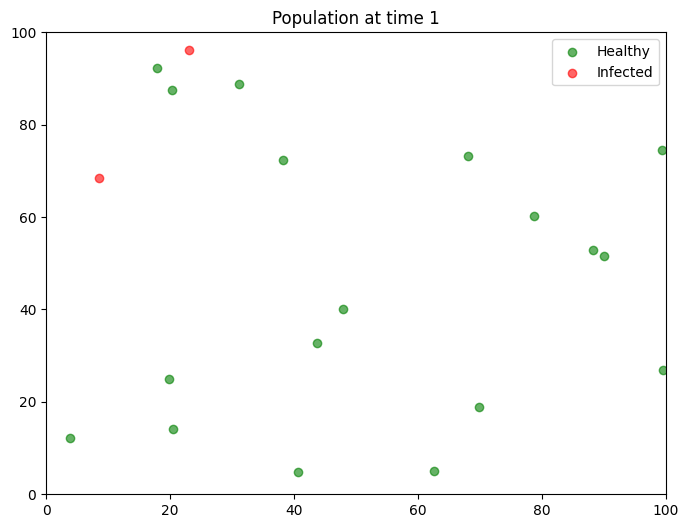

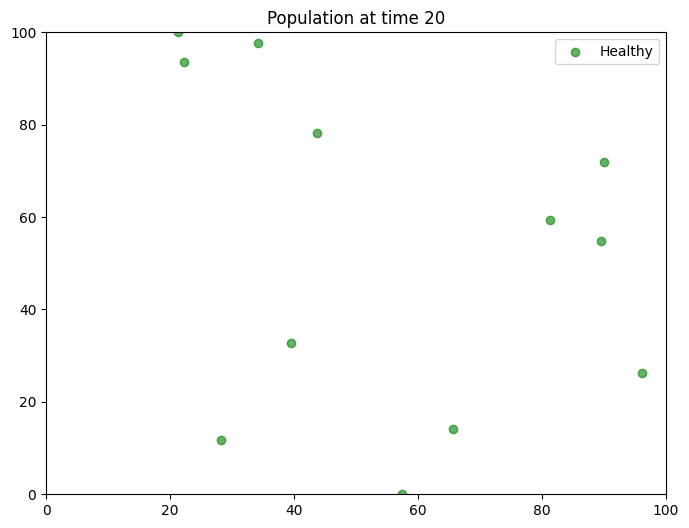

In [32]:
# Example usage:
viz = Visualizer(df_movements)
viz.plot_snapshot(time_point=1)
viz.plot_snapshot(time_point=20)


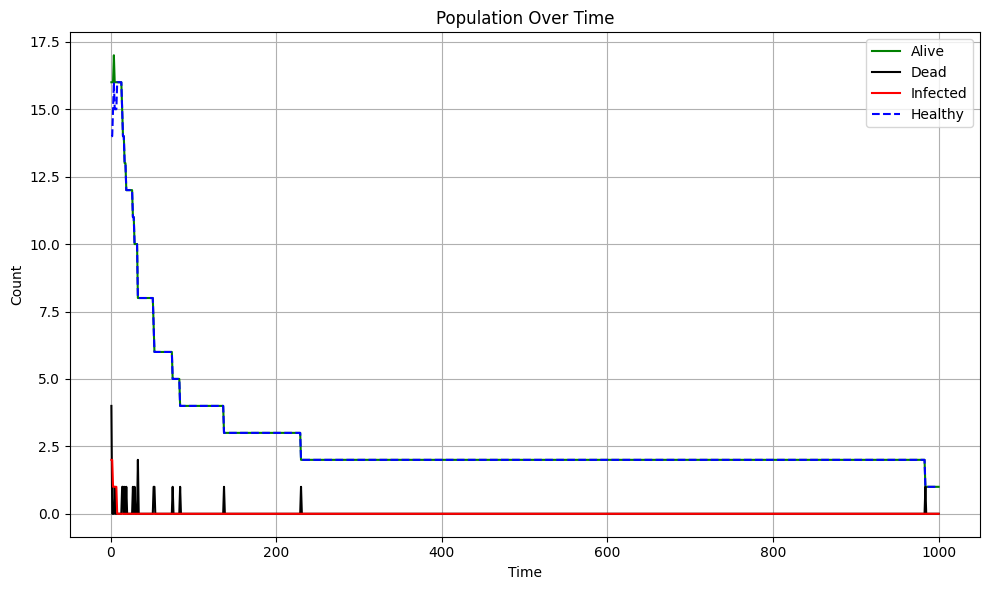

In [33]:
viz.plot_population_summary()

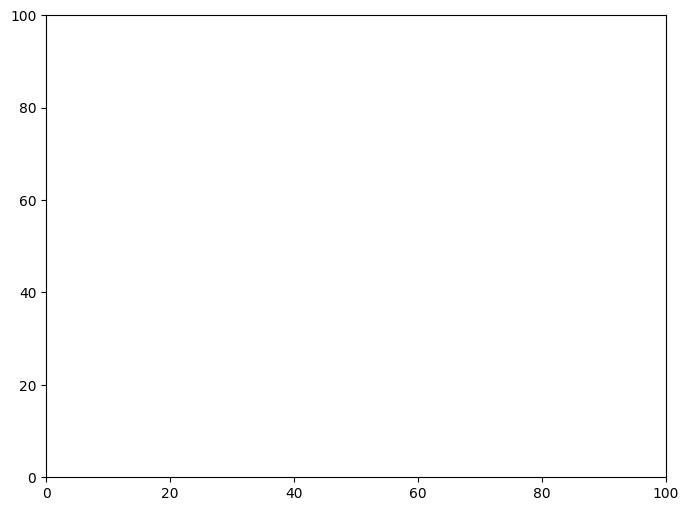

In [34]:
viz.animate_simulation()